# Tae-Seung Kim Module 6

In [231]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score, average_precision_score, roc_curve, precision_recall_fscore_support, precision_recall_curve, confusion_matrix, classification_report

In [134]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = 12, 7

In [232]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_= pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
        x = pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x = x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0

In [171]:
class rfmodel:
    # on creation
    def __init__(self, name, data, seed=1, split=True, model=RandomForestClassifier(n_estimators=100,random_state=1)):
        self.name = name
        self.data = data.copy()
        self.seed = seed
        self.model = model
        self.split = split

    def splitdata(self, test_size=0.2):
        if self.split == True:
            self.xdata = self.data.copy().drop(['target'], axis=1)
            #dividends included is the target
            self.ydata = self.data['target'].copy()
            #any target giving > 0 returns is a good enough trade
            self.X_Train, self.X_Test, self.Y_Train, self.Y_Test = train_test_split(self.xdata, self.ydata, test_size=test_size, random_state=1)
        else:
            self.xdata = self.data.copy().drop(['target'], axis=1)
            self.ydata = self.data['target'].copy()
            self.X_Train = self.xdata
            self.Y_Train = self.ydata

    def featImpMDA_classify(self,cv=10):
        X = self.xdata
        y = self.ydata
        np.random.seed(self.seed)
        # feat importance based on OOS score reduction
        print('start MDA',dt.datetime.now())
        from sklearn.metrics import log_loss
        cvGen=KFold(n_splits=cv)
        scr0,scr1=pd.Series(dtype='float64'),pd.DataFrame(columns=X.columns)
        for i,(train,test) in enumerate(cvGen.split(X=X)):
            print('   Split',i+1)
            X0, y0=X.iloc[train,:],y.iloc[train]
            X1, y1=X.iloc[test,:],y.iloc[test]  
            fit=self.model.fit(X=X0,y=y0.values.ravel())
            pred=fit.predict_proba(X1)
            #neg log loss from snippet 8.3
            scr0.loc[i]=-log_loss(y1,pred[:,1], sample_weight=None, labels=self.model.classes_)
            for j in X.columns:
                X1_=X1.copy(deep=True)
                np.random.shuffle(X1_[j].values) # permutation of a single column
                pred=fit.predict_proba(X1_)
            
                scr1.loc[i,j]=-log_loss(y1,pred[:,1], sample_weight=None, labels=self.model.classes_)
        #neg log loss from snippet 8.3
        imp=(-scr1).add(scr0,axis=0)
        imp=imp/-scr1
        imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
        print('end MDA',dt.datetime.now())
        self.imp_raw = imp
        self.imp = self.imp_raw.reset_index().rename(index=int,
                                                columns={"index":"Feature",'mean':'Importance'}, 
                                                inplace=False).set_index('Feature')
        self.imp = self.imp.sort_values(by='Importance')
        self.scr0 = scr0
        self.scr1 = scr1

    def fit(self):
        self.model.fit(self.X_Train, self.Y_Train)

    def pred(self):
        if self.split == True:
            self.Y_Pred_Train = self.model.predict(self.X_Train)
            self.Y_Pred_Test = self.model.predict(self.X_Test)
            self.train_probs = self.model.predict_proba(self.X_Train)
            self.test_probs = self.model.predict_proba(self.X_Test)
            self.train_probs = self.train_probs[:,1]
            self.test_probs = self.test_probs[:,1]
        else:
            self.preds = self.model.predict(self.xdata)
            self.probs = self.model.predict_proba(self.xdata)
            self.probs = self.probs[:,1]
        

    def getAccuracy(self):
        if self.split == True:
            self.precision_train, self.precision_train, self.train_threshold = metrics.precision_recall_curve(self.Y_Train, self.train_probs)
            self.precision_test, self.precision_test, self.test_threshold = metrics.precision_recall_curve(self.Y_Test, self.test_probs)
            self.auc_train = average_precision_score(self.Y_Train, self.Y_Pred_Train)
            self.auc_test = average_precision_score(self.Y_Test, self.Y_Pred_Test)
            self.train_acc = metrics.accuracy_score(self.Y_Train, self.Y_Pred_Train)
            self.test_acc = metrics.accuracy_score(self.Y_Test, self.Y_Pred_Test)
            self.f1_train = f1_score(self.Y_Train, self.Y_Pred_Train)
            self.f1_test = f1_score(self.Y_Test, self.Y_Pred_Test)
            self.bigscoretest = precision_recall_fscore_support(self.Y_Test, self.Y_Pred_Test, average='binary')
            self.bigscoretrain = precision_recall_fscore_support(self.Y_Train, self.Y_Pred_Train, average='binary')
        else:
            self.precision, self.recall, self.threshold = metrics.precision_recall_curve(self.ydata, self.probs)
            self.auc = average_precision_score(self.ydata, self.preds)
            self.acc = metrics.accuracy_score(self.ydata, self.preds)
            self.f1 = f1_score(self.ydata, self.preds)
            self.bigscore = precision_recall_fscore_support(self.ydata, self.preds, average='binary')

    def makePRplot(self):
        if self.split == True:
            self.plot1 = PrecisionRecallDisplay.from_predictions(self.Y_Test, self.Y_Pred_Test, drawstyle="default")
            self.plot1.ax_.set_title(self.name + " Test Precision Recall Curve")
            self.plot2 = PrecisionRecallDisplay.from_predictions(self.Y_Train, self.Y_Pred_Train, drawstyle="default")
            self.plot2.ax_.set_title(self.name + " Train Precision Recall Curve")
            #plt.show()
        else:
            self.plot = PrecisionRecallDisplay.from_predictions(self.ydata, self.probs, drawstyle="default")
            self.plot.ax_.set_title(self.name + " Precision Recall Curve")
            #plt.show()
    
    def makeROCplot(self):
        if self.split == True:
            self.plot1 = RocCurveDisplay.from_predictions(self.Y_Test, self.Y_Pred_Test, drawstyle="default")
            self.plot1.ax_.set_title(self.name + " Test Precision Recall Curve")
            self.plot2 = RocCurveDisplay.from_predictions(self.Y_Train, self.Y_Pred_Train, drawstyle="default")
            self.plot2.ax_.set_title(self.name + " Train Precision Recall Curve")
        else:
            self.plot = RocCurveDisplay.from_predictions(self.ydata, self.probs, drawstyle="default")
            self.plot.ax_.set_title(self.name + " Precision Recall Curve")
            
        
    def plot_importances(self, save=None, xrot=0, tickstep=3,
                     label_fontsize=12,
                     figsize=None, scalefig=(1.0, 1.0), show=True):
        """
        Given an array or data frame of importances, plot a horizontal bar chart
        showing the importance values.

        :param df_importances: A data frame with Feature, Importance columns
        :type df_importances: pd.DataFrame
        :param save: A filename identifying where to save the image.
        :param xrot: Degrees to rotate importance (X axis) labels
        :type xrot: int
        :param tickstep: How many ticks to skip in X axis
        :type tickstep: int
        :param label_fontsize:  The font size for the column names and x ticks
        :type label_fontsize:  int
        :param figsize: Specify width and height of image (width,height)
        :type figsize: 2-tuple of floats
        :param scalefig: Scale width and height of image (widthscale,heightscale)
        :type scalefig: 2-tuple of floats
        :param show: Execute plt.show() if true (default is True). Sometimes
                    we want to draw multiple things before calling plt.show()
        :type show: bool
        :return: None

        SAMPLE CODE

        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
        X_train, y_train = ..., ...
        rf.fit(X_train, y_train)
        imp = importances(rf, X_test, y_test)
        plot_importances(imp)
        """
        df_importances = self.imp

        I = df_importances

        if figsize:
            fig = plt.figure(figsize=figsize)
        elif scalefig:
            fig = plt.figure()
            w, h = fig.get_size_inches()
            fig.set_size_inches(w * scalefig[0], h * scalefig[1], forward=True)
        else:
            fig = plt.figure()
        ax = plt.gca()
        labels = []
        for col in I.index:
            if isinstance(col, list):
                labels.append('\n'.join(col))
            else:
                labels.append(col)

        for tick in ax.get_xticklabels():
            tick.set_size(label_fontsize)
        for tick in ax.get_yticklabels():
            tick.set_size(label_fontsize)
        ax.barh(np.arange(len(I.index)), I.Importance, height=0.6, tick_label=labels)

        # rotate x-ticks
        if xrot is not None:
            plt.xticks(rotation=xrot)

        # xticks freq
        xticks = ax.get_xticks()
        nticks = len(xticks)
        new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
        ax.set_xticks(new_ticks)

        if save:
            plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
        if show:
            plt.show()



In [136]:
df = pd.read_csv('SPY1.csv')

In [137]:
df.columns = df.columns.str.replace(' ', '') 
df.columns = df.columns.str.lower()


In [138]:
df.isnull().sum()   

date        0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
dtype: int64

In [139]:
df.head()

,date,open,high,low,close,adjclose,volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,24.941402,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.118784,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.172003,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.438091,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,25.544525,531500


In [140]:
df.tail()

,date,open,high,low,close,adjclose,volume
7722,2023-09-29,431.670013,431.850006,425.910004,427.480011,427.480011,115078500
7723,2023-10-02,426.619995,428.600006,424.459991,427.309998,427.309998,83798600
7724,2023-10-03,425.059998,427.369995,420.179993,421.589996,421.589996,103760600
7725,2023-10-04,422.070007,425.429993,420.559998,424.660004,424.660004,87453000
7726,2023-10-05,424.359985,425.369995,421.170013,424.500000,424.500000,70103300


## Question 1

Download SPY data Download SPY data and the Probabilistic Sharpe Ratio. Backtest a naive trading strategy that buys SPY at a month’s end if RF predicts the SPX return will be positive next, and vice versa for shorts. (8 points)

In [141]:
df['date'] = pd.to_datetime(df['date'])

In [145]:
endofmonth = []
dateholder = []
current_month = 1
for i in df.index:
    if df['date'][i].month != current_month:
        current_month = df['date'][i].month
        endofmonth.append(df['date'][i-1].date())
    elif i == df.index[-1]:
        endofmonth.append(df['date'][i].date())
    else:
        continue
    

In [148]:
endofmonth = pd.DataFrame(endofmonth, columns=['date'])
endofmonth['date'] = pd.to_datetime(endofmonth['date'])
eom_df = df[df['date'].isin(endofmonth['date'])].copy()
eom_df.set_index('date', inplace=True)

#df['log_returns'] = np.log(df['close']/df['close'].shift(1)).dropna()
eom_df['log_returns'] = np.log(eom_df['close']) - np.log(eom_df['close'].shift(1))
eom_df.dropna(inplace=True)

In [150]:
eom_df['target'] = np.where(eom_df['log_returns'] > 0, 1, -1)

In [153]:
eom_df.head()

,open,high,low,close,adjclose,volume,log_returns,target
date,,,,,,,,
1993-02-26,44.43750,44.43750,44.18750,44.40625,25.207478,66200,0.010612,1
1993-03-31,45.34375,45.46875,45.18750,45.18750,25.772120,111600,0.017440,1
1993-04-30,44.12500,44.28125,44.03125,44.03125,25.112652,88500,-0.025921,-1
1993-05-28,45.40625,45.40625,45.00000,45.21875,25.789928,79100,0.026612,1
1993-06-30,45.12500,45.21875,45.00000,45.06250,25.882969,437600,-0.003461,-1


In [224]:
# with 30 years of data we can split it into about 20 years of training and 10 years of testing
training = eom_df[eom_df.index < '2013-02-01'].drop(['log_returns'], axis=1)
testing = eom_df[eom_df.index >= '2013-01-01'].drop(['log_returns'], axis=1)

#training = eom_df[eom_df.index < '2013-02-01']
#testing = eom_df[eom_df.index >= '2013-01-01']

In [235]:
q1_model_train = rfmodel('q1_train', training, split=True)
q1_model_train.splitdata()
q1_model_train.fit()
q1_model_train.pred()
q1_model_train.getAccuracy()

q1_model_train.traincombined = q1_model_train.X_Train.copy()
q1_model_train.traincombined['predicted'] = q1_model_train.Y_Pred_Train

q1_model_train.testcombined = q1_model_train.X_Test.copy()
q1_model_train.testcombined['predicted'] = q1_model_train.Y_Pred_Test

q1_model_train.fulldata = pd.concat([q1_model_train.traincombined, q1_model_train.testcombined], axis=0)
q1_model_train.fulldata.head()

,open,high,low,close,adjclose,volume,predicted
date,,,,,,,
1993-02-26,44.437500,44.437500,44.187500,44.406250,25.207478,66200,1
2007-08-31,147.649994,148.500000,146.830002,147.589996,107.649895,185477500,1
1999-03-31,131.156250,131.609375,128.312500,128.375000,82.517868,7413600,1
2008-05-30,140.470001,140.740005,139.940002,140.350006,103.912613,117362000,1
2005-06-30,120.220001,120.320000,118.949997,119.180000,83.844490,62288800,-1


In [226]:
q1_model_test = rfmodel('q1_test', testing, split=False, model=q1_model_train.model)
q1_model_test.splitdata()
q1_model_test.pred()
q1_model_test.getAccuracy()

q1_model_test.fulldata = q1_model_test.X_Train.copy()
q1_model_test.fulldata['predicted'] = q1_model_test.preds
q1_model_test.fulldata.head()

,open,high,low,close,adjclose,volume,predicted
date,,,,,,,
2013-01-31,149.889999,150.380005,149.600006,149.699997,122.966431,108975800,1
2013-02-28,151.899994,152.869995,151.410004,151.610001,124.535378,126866000,1
2013-03-28,156.089996,156.850006,155.750000,156.669998,129.264114,102932800,1
2013-04-30,159.270004,159.720001,158.610001,159.679993,131.747589,116010700,1
2013-05-31,165.369995,166.309998,163.130005,163.449997,134.858093,176850100,1


In [227]:
mod_list = [q1_model_train, q1_model_test]

bigholder = []
for x in mod_list:
    if x.split==True:
        smallholder = {}
        smallholder['model'] = x.name
        smallholder['precision_train'] = x.bigscoretrain[0]
        smallholder['recall_train'] = x.bigscoretrain[1]
        smallholder['f1_train'] = x.bigscoretrain[2]
        smallholder['auc_train'] = x.auc_train
        smallholder['precision_test'] = x.bigscoretest[0]
        smallholder['recall_test'] = x.bigscoretest[1]
        smallholder['f1_test'] = x.bigscoretest[2]
        smallholder['auc_test'] = x.auc_test
        bigholder.append(smallholder)
    else:
        smallholder = {}
        smallholder['model'] = x.name
        smallholder['precision'] = x.bigscore[0]
        smallholder['recall'] = x.bigscore[1]
        smallholder['f1'] = x.bigscore[2]
        smallholder['auc'] = x.auc
        bigholder.append(smallholder)

In [228]:
q1_model_test.featImpMDA_classify()

start MDA 2024-02-09 20:17:34.410190
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2024-02-09 20:17:36.071817


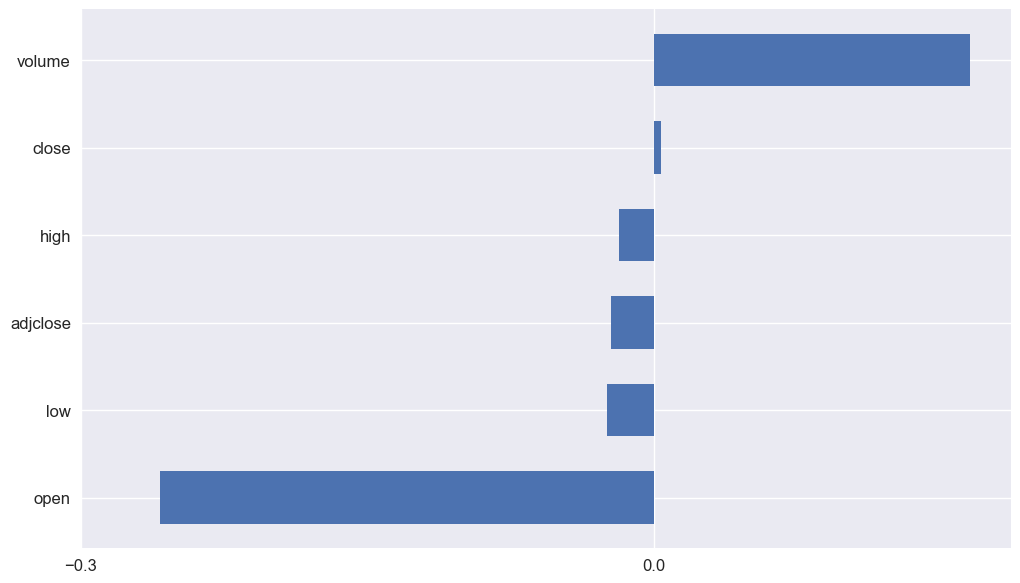

In [229]:
q1_model_test.plot_importances()

In [230]:
scores_df = pd.DataFrame(bigholder)
scores_df

,model,precision_train,recall_train,f1_train,auc_train,precision_test,recall_test,f1_test,auc_test,precision,recall,f1,auc
0,q1_train,1.0,1.0,1.0,1.0,0.827586,0.705882,0.761905,0.792512,NaN,NaN,NaN,NaN
1,q1_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.674419,1.0,0.805556,0.674419


In [233]:
mod_list = [q1_model_train, q1_model_test]

In [243]:
q1_model_fulldata = pd.concat([q1_model_train.fulldata, q1_model_test.fulldata], axis=0)
q1_model_fulldata = q1_model_fulldata.merge(eom_df['target'], how='left', left_index=True, right_index=True)
q1_model_fulldata['correct'] = np.where(q1_model_fulldata['predicted'] == q1_model_fulldata['target'], 1, 0)
q1_model_fulldata.sort_index(inplace=True)
q1_model_fulldata['log_return'] = np.log(q1_model_fulldata['close']) - np.log(q1_model_fulldata['close'].shift(1))

In [245]:
q1_model_fulldata['short_return'] = np.where(q1_model_fulldata['predicted'] == -1, -1*q1_model_fulldata['log_return'], 0)
q1_model_fulldata['long_return'] = np.where(q1_model_fulldata['predicted'] == 1, q1_model_fulldata['log_return'], 0)

In [247]:
q1_model_fulldata['total_return'] = q1_model_fulldata['short_return'] + q1_model_fulldata['long_return']

In [248]:
q1_model_fulldata_total_return = 

,open,high,low,close,adjclose,volume,predicted,target,correct,log_return,short_return,long_return,total_return
date,,,,,,,,,,,,,
1993-02-26,44.437500,44.437500,44.187500,44.406250,25.207478,66200,1,1,1,NaN,0.000000,NaN,NaN
1993-03-31,45.343750,45.468750,45.187500,45.187500,25.772120,111600,1,1,1,0.017440,0.000000,0.017440,0.017440
1993-04-30,44.125000,44.281250,44.031250,44.031250,25.112652,88500,-1,-1,1,-0.025921,0.025921,0.000000,0.025921
1993-05-28,45.406250,45.406250,45.000000,45.218750,25.789928,79100,1,1,1,0.026612,0.000000,0.026612,0.026612
1993-06-30,45.125000,45.218750,45.000000,45.062500,25.882969,437600,1,-1,0,-0.003461,0.000000,-0.003461,-0.003461
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,441.440002,444.299988,441.109985,443.279999,441.721893,104921500,1,1,1,0.059079,0.000000,0.059079,0.059079
2023-07-31,457.410004,458.160004,456.049988,457.790009,456.180908,62040400,1,1,1,0.032209,0.000000,0.032209,0.032209
2023-08-31,451.649994,452.829987,450.160004,450.350006,448.767059,66084600,1,-1,0,-0.016386,0.000000,-0.016386,-0.016386
